In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import glob
import json

# First, let's open the hdf5 and template files for Hanover and Livingston detectors and plot the raw data

In [2]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    tp=template[0]
    tx=template[1]
    return tp,tx

def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

In [3]:
h_file = "LOSC_Event_tutorial-master/H-H1_LOSC_4_V2-1126259446-32.hdf5"
l_file = "LOSC_Event_tutorial-master/L-L1_LOSC_4_V2-1126259446-32.hdf5"
template = 'LOSC_Event_tutorial-master/GW150914_4_template.hdf5'

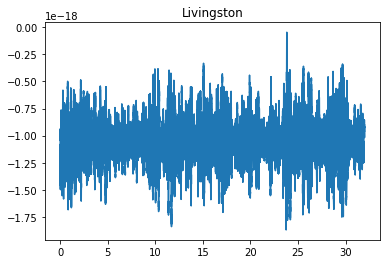

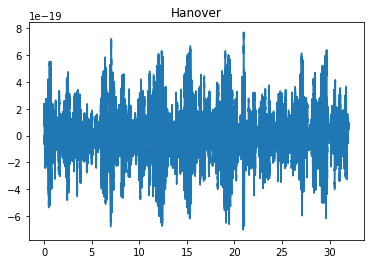

Text(0.5, 1.0, 'Template')

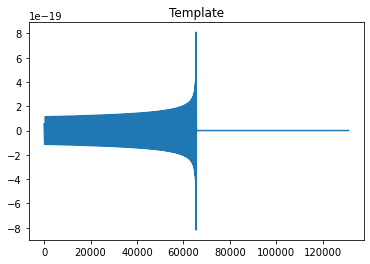

In [4]:
l_strain,l_dt,l_utc=read_file(l_file)
h_strain,h_dt,h_utc=read_file(h_file)
tp,tx=read_template(template)

l_time = np.arange(0,l_dt*len(l_strain),l_dt)
h_time = np.arange(0,h_dt*len(h_strain),h_dt)

plt.plot(l_time,l_strain)
plt.title("Livingston")
plt.show()

plt.plot(h_time,h_strain)
plt.title("Hanover")
plt.show()

plt.plot(tp)
plt.title("Template")

# Estimate the noise in the each detector separately

### We'll start by using a window function and then taking the FT to avoid FFT ringing

We want a window that is wide in the centre, so we don't accidentally get rid of the signal by windowing. To do this, we'll use the Turkey window (https://en.wikipedia.org/wiki/Window_function#:~:text=window%20(or%20function).-,Tukey%20window,-%5Bedit%5D), which is a cosine lobe convolved with a rectangle window.

For a rectangle of width $N(1 − \alpha/2)$, this mathematically looks like:

$ w[n] = \frac{1}{2}[1-cos(\frac{2\pi n}{\alpha N})] ,\ 0 \leq n \leq \frac{\alpha N}{2}$

$ w[n] = 1,\ \frac{\alpha N}{2} \leq n \leq \frac{N}{2}$

$ w[N-n] = w[n],\ 0 \leq n \leq \frac{N}{2}$

This is all emcompassed in the `window` function

### Then we want to convolve with a Gaussian kernel to smooth out the noise
This is done with Jon's `smooth_vector` function from `ligo_class.py` - it takes input as the correlated noise and then smooths it by convolving a Gaussian kernel with the data.

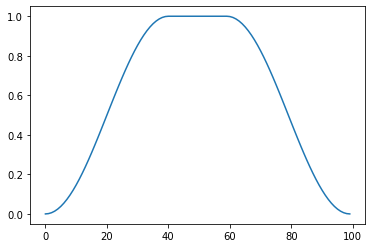

In [131]:
def window(alpha, N):
    arr = np.zeros(N)
    for n in range(len(arr)):
        if (n >= 0) and (n < (alpha*N)/2):
            arr[n] = 0.5*(1-np.cos((2*np.pi*n)/(alpha*N)))
        if ((n >= (alpha*N)/2)) and (n <= N/2):
            arr[n] = 1
        if (n >= 0) and (n <= N/2):
            arr[N-n-1] = arr[n]
    return arr

def smooth_vector(vec,sig):
    n=len(vec)
    x=np.arange(n)
    x[n//2:]=x[n//2:]-n
    kernel=np.exp(-0.5*x**2/sig**2) #make a Gaussian kernel
    kernel=kernel/kernel.sum()
    vecft=np.fft.rfft(vec)
    kernelft=np.fft.rfft(kernel)
    vec_smooth=np.fft.irfft(vecft*kernelft) #convolve the data with the kernel
    return vec_smooth
plt.plot(window(0.8,100))

The noise model windows the strain data, then smooths with a gaussian kernel. I made `smooth_ps` to plot the smoothed noise in the plots below.

In [57]:
def get_noise_model(strain,resize=True):
    win = window(0.8,len(strain)) #window with a Turkey window with alpha = 0.8
    ft_windowed = np.fft.fft(strain*win) #window our strain data
    ps = np.abs(ft_windowed)**2 #take the ps of windowed data
    smooth = smooth_vector(ps,5) #smooth with a gaussian of width 10
    if resize:
        smooth = smooth[:len(ft_windowed)//2+1]
    Ninv = 1/smooth
    return Ninv

In [174]:
def smooth_ps(strain):
    win = window(0.6,len(strain)) #window with a Turkey window with alpha = 0.8
    ft_windowed = np.fft.fft(strain*win) #window our strain data
    ps = np.abs(ft_windowed)**2 #take the ps of windowed data
    smooth = smooth_vector(ps,5) #smooth with a gaussian of width 10
    #smooth = smooth[:len(ft_windowed)//2+1]
    return smooth

# b) Use the noise model Ninv to search the 4 sets of events using a matched filter

I adapted some code from the `LOSC_Event_tutorial` notebook to open and read the .json file. This then stores each event in an array (one for each detector) as well as the templates in their own array for easy access when we need to loop through them.

The function `mf_data` reads in a data file (`data_file`) and a template file (`temp_file`). Some of the lines in this code are taken from Jon's `mf_ligo_class.py`. The function performs a matched filter by convolving the Fourier transform of the strain data with the conjugate of the correlation of the noise matrix (from above) with the template's FT. It returns `rhs`, with is the matched filter output.

Below are the plotted MF of each event (FFT shifted so that power is in the centre of the plot). We can clearly see spikes where there is a GW!

In [317]:
eventnames = np.asarray(['GW150914','GW151226','GW170104'])
fnjson = "LOSC_Event_tutorial-master/BBH_events_v3.json"
fn_H1 = np.array(())
fn_L1 = np.array(())
fn_template = np.array(())

for eventname in eventnames:
    events = json.load(open(fnjson,"r"))
    event = events[eventname]
    fn_H1 = np.append(fn_H1,event['fn_H1'])              # File name for H1 data
    fn_L1 = np.append(fn_L1,event['fn_L1'])              # File name for L1 data
    fn_template = np.append(fn_template,event['fn_template'])

### Let's look at the noise to make sure our noise model from a) works

Also see above for the noise function w/o windowing. We'll use this in plotting to see the difference between the two noise models. In the Hanover detector, we can see that windowing the noise gets rid of the weird flat part around 100 Hz and makes it look more like the LIGO tutorial noise does.

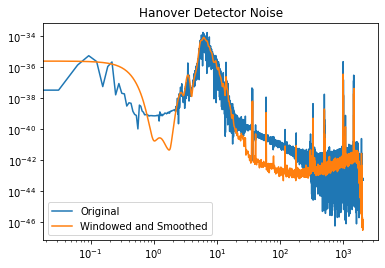

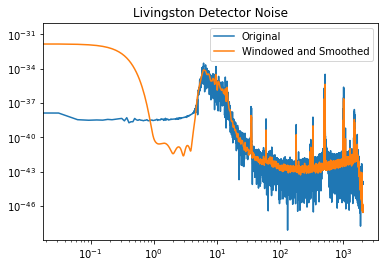

In [171]:
strain_h,dt_h,utc_h = read_file('LOSC_Event_tutorial-master/'+fn_H1[0])
strain_l,dt_l,utc_l = read_file('LOSC_Event_tutorial-master/'+fn_L1[0])

t_tot = dt_h*len(strain_h)
d_nu = 1/t_tot

noise_h = smooth_ps(strain_h)
noise_l = smooth_ps(strain_l)

noise_h = noise_h/len(noise_h)
noise_l = noise_l/len(noise_l)

nu_vec = np.arange(len(noise_h))*d_nu

noise_h_now = np.abs(np.fft.rfft(strain_h))[:len(nu_vec)]**2 / len(strain_h)
noise_l_now = np.abs(np.fft.rfft(strain_l))[:len(nu_vec)]**2 / len(strain_h)

plt.loglog(nu_vec,noise_h_now,label='Original')
plt.loglog(nu_vec,noise_h,label='Windowed and Smoothed')
plt.title('Hanover Detector Noise')
plt.legend()
plt.show()

plt.loglog(nu_vec,noise_l_now,label='Original')

plt.loglog(nu_vec,noise_l,label='Windowed and Smoothed')
plt.title('Livingston Detector Noise')
plt.legend()
plt.show()

### Now we search for the signal using matched filters

The `mf_data` function reads in the template and data file for the given detector + event, then does a typical MF by convolving the FT data with the FT of the template

In [61]:
def mf_data(data_file,temp_file):
    temp,tx = read_template('LOSC_Event_tutorial-master/'+temp_file)
    strain,dt,utc = read_file('LOSC_Event_tutorial-master/'+data_file)
    template_ft=np.fft.rfft(temp*window(0.8,len(temp)))
    template_filt=template_ft*get_noise_model(strain)
    data_ft=np.fft.rfft(strain*window(0.8,len(strain)))
    rhs=np.fft.irfft(data_ft*np.conj(template_filt))
    return rhs, get_noise_model(strain)

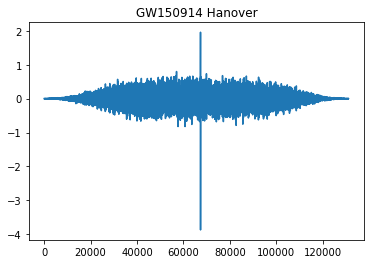

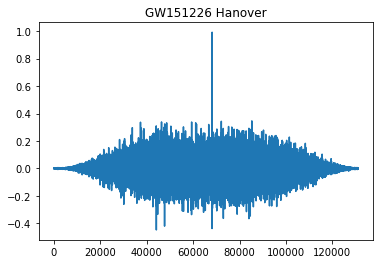

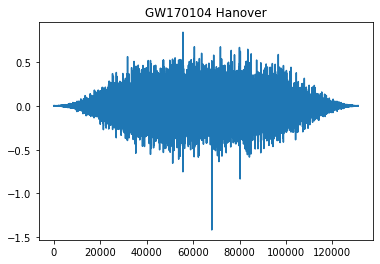

In [63]:
for i in range(len(fn_H1)):
    plt.title(eventnames[i] + ' Hanover')
    plt.plot(np.fft.fftshift(mf_data(fn_H1[i],fn_template[i])[0]))
    #noises_h = np.append(noises_h,mf_data(fn_H1[i],fn_template[i])[1])
    plt.show()

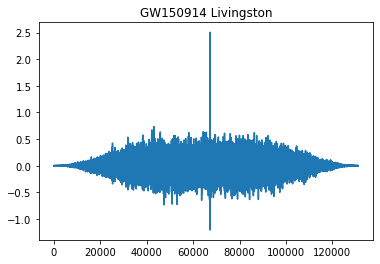

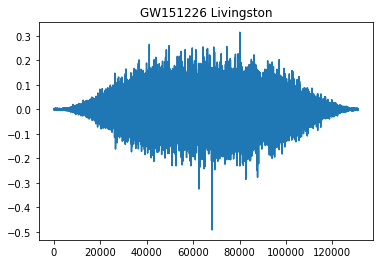

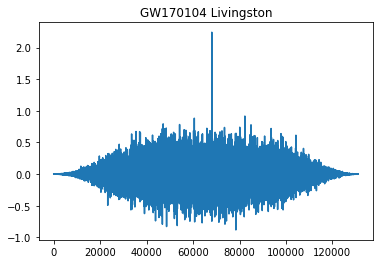

In [64]:
noises_l = np.array(())
for i in range(len(fn_L1)):
    plt.title(eventnames[i] + ' Livingston')
    plt.plot(np.fft.fftshift(mf_data(fn_L1[i],fn_template[i])[0]))
    #noises_l = np.append(noises_l,mf_data(fn_L1[i],fn_template[i])[1])
    plt.show()

# c) Estimate noise for each event and find the SNR

To estimate noise, we'll take the scatter far away from the signal (but where our window function is still flat) - between 80000 and 85000 looks good.

The signal is taken to be the max power of the MF divided by the estimated noise (this can be either positive or negative, so let's take the max of the absolute value of the two peaks).

We can combine both detectors by adding the SNR in quadrature, i.e., $SNR_{tot} = \sqrt{SNR_{Liv}^2 + SNR_{Han}^2}$

In [287]:
snr = np.array(())

for i in range(len(fn_L1)):
    mf_l = np.fft.fftshift(mf_data(fn_L1[i],fn_template[i])[0])
    mf_h = np.fft.fftshift(mf_data(fn_H1[i],fn_template[i])[0])
    noise_l = np.std(mf_l[80000:85000])
    noise_h = np.std(mf_h[80000:85000])
    
    snr_l = mf_l/noise_l
    snr_h = mf_l/noise_l

    snr = np.append(snr,np.sqrt(max(np.abs(snr_l))**2 + max(np.abs(snr_h))**2))

print("Signal to noise ratios are:")
print(f"GW150914: {snr[0]}")
print(f"GW151226: {snr[1]}")
print(f"GW170104: {snr[2]}")

Signal to noise ratios are:
GW150914: 18.101492518648755
GW151226: 9.79100876822694
GW170104: 14.42816701099982


# d) Compare the SNR from scatter to the analytic SNR from noise model

This is somewhat inspired by the LIGO tutorial: we want to normalize the matched filter output so that we expect a value of 1 at times of just noise. Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.

The analytic noise model here is `power_vec_l` and `power_vec_h`. In this case, $\sigma = \sum A A^* N^{-1}$ where $SNR = max(\frac{MF}{\sigma})$

These don't match but are roughly the same OOM (though the scalings change) - not entirely sure why this is, since the noise estimated from scatter gives a better SNR than analytical (analytical values seem a bit small), so there must be something off with my method for calculating analytical SNR.

In [207]:
for i in range(len(fn_template)):
        
    strain_h,dt_h,utc_h = read_file('LOSC_Event_tutorial-master/'+ fn_H1[i])
    strain_l,dt_l,utc_l = read_file('LOSC_Event_tutorial-master/'+ fn_L1[i])
    
    power_vec_l = np.sqrt(get_noise_model(strain_l,resize=False))
    power_vec_h = np.sqrt(get_noise_model(strain_h,resize=False))

    template,tx = read_template('LOSC_Event_tutorial-master/'+ fn_template[i])
    template_fft = np.fft.fft(template*window(0.8,len(template)))
    
    sigmasq_l = ((template_fft * template_fft.conjugate()) * power_vec_l).sum() 
    sigmasq_h = ((template_fft * template_fft.conjugate()) * power_vec_h).sum()
    sigma_l = np.sqrt(np.abs(sigmasq_l))*np.size(template_fft)
    sigma_h = np.sqrt(np.abs(sigmasq_h))*np.size(template_fft)
    
    
    SNR_complex_l = mf_l/sigma_l
    SNR_complex_h = mf_h/sigma_h
    
    SNR_tot =np.sqrt(SNR_complex_l**2 + SNR_complex_h**2)
    print(f"SNR for {eventnames[i]}: {max(SNR_tot)}")

SNR for GW150914: 2.3169809837733215
SNR for GW151226: 5.855285618780727
SNR for GW170104: 2.2076846410795827


# e) Find the frequency from each event where half the weight comes from above that frequency and half from below

Weights are computed with $\frac{FFT\ template}{N}$ in Fourier space, where N is the noise matrix ($1/N_{inv}$) To figure out the weights at each frequency, we'll take the cumulative sum and normalize by dividing by the total sum. The frequency we're looking for is where this value > 0.5. We can find the index of this and get the `nu_vec` value at that index.

The frequencies at which this happens are ~130 Hz (see exact numbers below). This correlates with the region where we see our detector noise plot above "bottom out".

Note that I needed to use a different `get_noise_model` function just to use the rfft instead of fft - weights behave weird when there are imaginary numbers.

GW150914


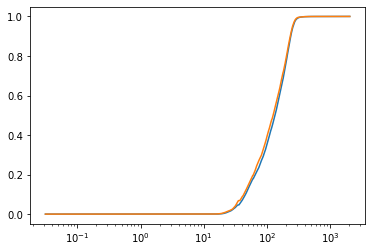

Hanover Frequency: 125.0625 Hz
Livingston Frequency: 134.25 Hz
GW151226


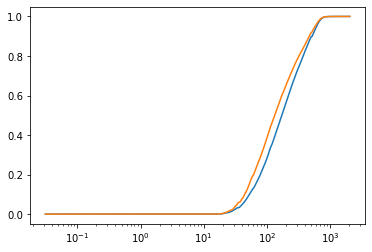

Hanover Frequency: 132.9375 Hz
Livingston Frequency: 171.78125 Hz
GW170104


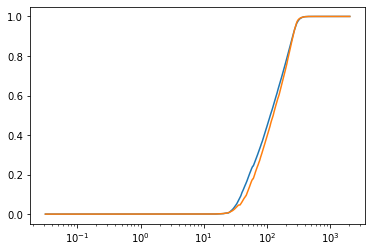

Hanover Frequency: 125.84375 Hz
Livingston Frequency: 113.125 Hz


In [307]:
def get_noise_model2(strain,resize=True):
    win = window(0.8,len(strain)) #window with a Turkey window with alpha = 0.8
    ft_windowed = np.fft.rfft(strain*win) #window our strain data
    ps = np.abs(ft_windowed)**2 #take the ps of windowed data
    smooth = smooth_vector(ps,5) #smooth with a gaussian of width 10
    if resize:
        smooth = smooth[:len(ft_windowed)//2+1]
    Ninv = 1/smooth
    return Ninv

for i in range(len(fn_template)):
    
    print(eventnames[i])
        
    strain_h,dt_h,utc_h = read_file('LOSC_Event_tutorial-master/'+ fn_H1[i])
    strain_l,dt_l,utc_l = read_file('LOSC_Event_tutorial-master/'+ fn_L1[i])

    template,tx = read_template('LOSC_Event_tutorial-master/'+ fn_template[i])
    template_fft = np.fft.rfft(template*window(0.8,len(template)))
    
    nu_arr = np.fft.rfftfreq(len(strain_l),dt_l)
    
    power_vec_l = np.sqrt(get_noise_model2(strain_l,resize=False))
    power_vec_h = np.sqrt(get_noise_model2(strain_h,resize=False))
    
    weights_l = np.abs(template_fft[1:]*power_vec_l)
    weights_h = np.abs(template_fft[1:]*power_vec_h)
    
    sum_weights_l = np.sum(weights_l)
    sum_weights_h = np.sum(weights_h)
    
    cumsum_l = np.cumsum(weights_l)
    cumsum_h = np.cumsum(weights_h)

    plt.plot(nu_arr[1:],cumsum_l/sum_weights_l)
    plt.plot(nu_arr[1:],cumsum_h/sum_weights_h)
    plt.xscale('log')
    plt.show()
    freq_h = nu_arr[np.argwhere(cumsum_h/sum_weights_h > 0.5)[0][0]]
    freq_l = nu_arr[np.argwhere(cumsum_l/sum_weights_l > 0.5)[0][0]]

    print(f"Hanover Frequency: {freq_h} Hz")
    print(f"Livingston Frequency: {freq_l} Hz")
    print("=========================================================")

# f) Localize time of arrival. What is the typical uncertainty for detectors a few thousand km apart?

Let's plot the MF output with the proper time axis (it was already in regular space, since the MF iffts back). Then we'll find the time where the amplitude is at its peak (max amplitude). 

We'll just do this for the first GW event, since the uncertainty should be the same for the others. I take the FWHM/2.355 (https://en.wikipedia.org/wiki/Full_width_at_half_maximum) as the uncertainty on the time localization.

Given that the detectors are located O(1000) km apart and GW travel at the speed of light, the uncertainty in position comes from the difference in arrival times $8.5 \times 10^{-8} s$:

$\Delta p = \frac{c \Delta t}{B}$, where p is position and B is the baseline (use 1000 km).

$\Rightarrow \Delta p = 0.0000255\ radians$

TOA at Livingston = 2015-09-14T09:50:30.433 +/- 0.0008293524416135881 s
TOA at Hanover = 2015-09-14T09:50:30.440 +/- 0.0018660429936305733 s
Difference in arrival times: 8.477105034598864e-08 s


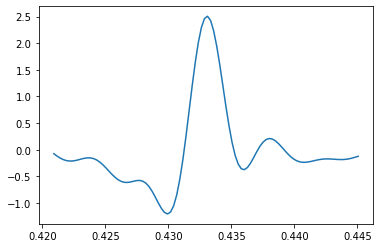

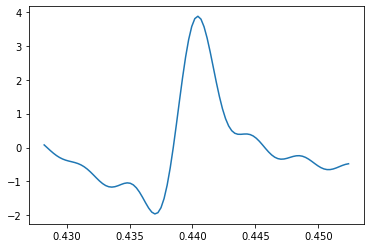

In [349]:
from astropy.time import Time, TimeDelta
l_strain,l_dt,l_utc=read_file('LOSC_Event_tutorial-master/'+fn_L1[0])
h_strain,h_dt,h_utc=read_file('LOSC_Event_tutorial-master/'+fn_H1[0])
#time_vec = np.arange(0,len(l_strain))*l_dt

mf_l = mf_data(fn_L1[0],fn_template[0])[0]
mf_h = mf_data(fn_H1[0],fn_template[0])[0]
    
amp_l = np.max(np.abs(mf_l))
amp_h = np.max(np.abs(mf_l))
        
idx_l = np.argmax(np.abs(mf_l))
idx_h = np.argmax(np.abs(mf_h))
        
time_vec=np.arange(len(mf_l))*l_dt
toa_l = time_vec[idx_l]
toa_h = time_vec[idx_h]

#print(Time(l_utc))

idx_err_l = np.argwhere(amp_l/2<np.abs(mf_l[idx_l-30:idx_l+30]))
idx_err_h = np.argwhere(amp_h/2<np.abs(mf_h[idx_l-30:idx_l+30]))

err_l=((idx_err_l[-1]-idx_err_l[0])*dt_l)/2.355
err_h=((idx_err_h[-1]-idx_err_h[0])*dt_h)/2.355

print(f"TOA at Livingston = {Time(l_utc)+ TimeDelta(time_vec[idx_l],format='sec')} +/- {err_l[0]} s")
print(f"TOA at Hanover = {Time(h_utc)+ TimeDelta(time_vec[idx_h],format='sec')} +/- {err_h[0]} s")

time_diff = np.abs(Time(l_utc)+ TimeDelta(time_vec[idx_l],format='sec')-(Time(h_utc)+ TimeDelta(time_vec[idx_h],format='sec')))

print(f'Difference in arrival times: {time_diff} s')

plt.plot(time_vec[idx_l-50:idx_l+50],mf_l[idx_l-50:idx_l+50])
plt.show()
plt.plot(time_vec[idx_h-50:idx_h+50],-mf_h[idx_h-50:idx_h+50])
plt.show()

### (I haven't taken 512, so didn't do part h)

# 2. Radio dish illuminated by a feed of Gaussian beam pattern: What value of $\sigma$ maximizes the signal at the feed?

$\sigma$ is in units of the dish size, so a $\sigma$ of 1 means the feed beam is at exp(-0.5) relative to the feed beam at the center of the dish. The thing we want to maximize is the temperature change at the receiver induced by the source, since the receiver noise is natively in temperature.

The effective area of the dish depends on the beam width (i.e., how much of the beam ends up on the primary), which comes from integrating:

$ A_{eff} = \int_{0}^{R} e^{-r/2\sigma^2} 2 \pi r \,dr = 2 \pi (4\sigma^4-(4\sigma^4+2R\sigma^2)e^{-R/2\sigma^2})$

We get the fraction of the dish that the beam takes up from dividing $\frac{A_{eff}}{A_{dish}}$, where $A_{dish}$ is just $\pi$, since $R = 1$.

We need to also get the fraction of the beam that lands on the ground if the beam size > dish size. This is because the signal will decrease due to ground temperature >> $\delta T$ from the signal

We do this by taking the ratio of $A_{eff}$ with the total integral of the beam (out to infinity, since we were given that assumption in the instructions): $A_{tot} = \int_{0}^{\infty} e^{-r/2\sigma^2} 2 \pi r \,dr$. 

Our total signal is given by:

$Signal = \frac{A_{eff}}{A_{tot}} \frac{A_{eff}}{A_{dish}}$,

Where $\frac{A_{eff}}{A_{tot}} = 1$ if the beam is not larger than the dish.

Optimal Beam Width: σ = 0.7114458110750843
A_eff/A @ peak: 0.34705478453399824
Fraction of beam off primary:0.3474798641565473


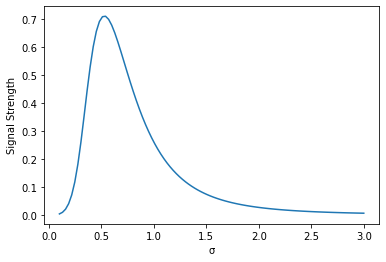

In [275]:
A_dish = np.pi
k = 1.38e-16
sigmas = np.linspace(0.1,3,100)
R = 1

signals = np.array(())
ratios = np.array(())
off_dish = np.array(())

for sigma in sigmas:
    A_eff = 2*np.pi*(4*sigma**4-(4*sigma**4+2*R*sigma**2)*np.exp(-R/(2*sigma**2)))
    ratio = A_eff/A_dish
    ratios = np.append(ratios,ratio)
    A_tot = 2*np.pi*sigma**4
    frac_on_dish = A_eff/A_tot
    off_dish = np.append(off_dish,1-frac_on_dish/A_dish)
    strength = ratio * frac_on_dish
    signals = np.append(signals,strength)
plt.xlabel('σ')
plt.ylabel('Signal Strength')
plt.plot(sigmas,signals)

print(f'Optimal Beam Width: σ = {max(signals)}')
print(f'A_eff/A @ peak: {ratios[np.argwhere(signals==max(signals))[0]][0]}')
print(f'Fraction of beam off primary:{off_dish[np.argwhere(signals==max(signals))[0]][0]}')